In [324]:
import os
import tarfile
import urllib
import shutil
import email
import nltk
import numpy as np
import sys
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
#nltk.download('stopwords')

from nltk.corpus import stopwords

from sklearn.ensemble import GradientBoostingClassifier



urls = ['https://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham.tar.bz2',
       'https://spamassassin.apache.org/old/publiccorpus/20021010_hard_ham.tar.bz2',
       'https://spamassassin.apache.org/old/publiccorpus/20021010_spam.tar.bz2',
       'https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham.tar.bz2',
       'https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham_2.tar.bz2',
       'https://spamassassin.apache.org/old/publiccorpus/20030228_hard_ham.tar.bz2',
       'https://spamassassin.apache.org/old/publiccorpus/20030228_spam.tar.bz2',
       'https://spamassassin.apache.org/old/publiccorpus/20030228_spam_2.tar.bz2',
       'https://spamassassin.apache.org/old/publiccorpus/20050311_spam_2.tar.bz2']

def spam_url_parser(url):
    """Checks a url to see if the data at the destination is ham or spam.
    Returns the string 'ham' if the data is ham and 'spam' if the data
    is spam."""
    
    # Get everything in string after the first '_'
    end_of_url = url.split('_', 1)[1]
    
    # Get everything before the '.tar.bz2' extension
    data_name = end_of_url.split('.')[0]
    
    if 'ham' in data_name.split('_'):
        return 'ham'
    return 'spam'


def get_unique_dirname(url):
    """To avoid overwriting files as we download the data we store in unique directory names
    based on the end of each url"""
    return url.split('/')[-1]

In [108]:
SPAM_PATH = os.path.join('spam_data')
HAM_PATH = os.path.join('ham_data')

def fetch_spam_data(urls):
    """This function goes through all of the urls and fetches the spam and
    ham data. The spam data is placed in the spam folder and the ham data
    is placed in the ham folder. We also do a check to see if the appropriate
    directories exists and if not we create them"""
    for url in urls:
        # need to make sure the directories are unique since the 
        # folder names within the zipped files are not unique
        # and we will end up overwriting data if we unzip in same
        # directory
        unique_dir_name = get_unique_dirname(url)
        if spam_url_parser(url) == 'spam':
            path = os.path.join(SPAM_PATH, unique_dir_name)
        else:
            path = os.path.join(HAM_PATH, unique_dir_name)
        if not os.path.isdir(path):
                os.makedirs(path)
        tgz_path = os.path.join(path, get_unique_dirname(url))
        urllib.request.urlretrieve(url, tgz_path)
        data_tgz = tarfile.open(tgz_path)
        data_tgz.extractall(path=path)
        data_tgz.close()
        os.remove(tgz_path)

In [111]:
# get the data

fetch_spam_data(urls)

In [112]:
# Move all of the files in the spam_data folder subdirectories
# to the 'spam_data' directory

count = 0
paths = [SPAM_PATH, HAM_PATH]

# Note the total number of files will reduce as there are a lot of
# duplicate files between the data sets we  copied over
for path in paths:
    for subdir, dirs, files in os.walk(path):
        for file in files:
            #print os.path.join(subdir, file)
            filepath = subdir + os.sep + file
            shutil.move(filepath, os.path.join(path, file))


In [116]:
# remove leftover directories
for path in paths:
    for subdir, dirs, files in os.walk(path):
        if subdir != 'spam_data' and subdir != 'ham_data':
            shutil.rmtree(subdir, ignore_errors=True)

In [117]:
def get_email_content(email_path):
    """Function used to extract the actual email body/content from
    each email"""
    file = open(email_path,encoding='latin1')
    try:
        msg = email.message_from_file(file)
        for part in msg.walk():
            if part.get_content_type() == 'text/plain':
                return part.get_payload() # prints the raw text
    except Exception as e:
        print(e)

In [209]:
content = [get_email_content('./ham_data/00001.1a31cc283af0060967a233d26548a6ce')]

content

['    Date:        Tue, 20 Aug 2002 17:27:47 -0500\n    From:        Chris Garrigues <cwg-exmh@DeepEddy.Com>\n    Message-ID:  <1029882468.3116.TMDA@deepeddy.vircio.com>\n\n\n  | I\'m hoping that all people with no additional sequences will notice are\n  | purely cosmetic changes.\n\nWell, first, when exmh (the latest one with your changes) starts, I get...\n\ncan\'t read "flist(totalcount,unseen)": no such element in array\n    while executing\n"if {$flist(totalcount,$mhProfile(unseen-sequence)) > 0} {\n\tFlagInner spool iconspool labelup\n    } else {\n\tFlagInner down icondown labeldown\n    }"\n    (procedure "Flag_MsgSeen" line 3)\n    invoked from within\n"Flag_MsgSeen"\n    (procedure "MsgSeen" line 8)\n    invoked from within\n"MsgSeen $msgid"\n    (procedure "MsgShow" line 12)\n    invoked from within\n"MsgShow $msgid"\n    (procedure "MsgChange" line 17)\n    invoked from within\n"MsgChange 4862 show"\n    invoked from within\n"time [list MsgChange $msgid $show"\n    (procedu

In [210]:
vectorizer = CountVectorizer(stop_words=list(stopwords.words('english')))
print(vectorizer.fit_transform(content).todense())
print(vectorizer.vocabulary_)

[[ 1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  4  1  1  1  1  1  5  1  1  1  1  1  4  1  1  1  1  2  3  1  2
   1  1  1  1  1  3  1  3  2  1  1  2  1  2  1  1  3  1  1  1  1  1  4  1
   1  1  1  1  2  1  1  2  2  2  1  1  1  1  2  1  2  1  1  1  3  1  1  1
   1  1  2  1  2  3  1  2  1  1  2  2 12  1  1  1  1  1  1  1  2  2  3 10
   2  3  1  1  1  1  1  2  2  2  2  1  1  1  2  1  1  1  1  1  2  1  1  1
   1  1  1  2  1  3  1  2  1  2 25  1  1  1  1  1  1  1  1  1  1  2 23 10
   1  1  1  1  1  2  2  1  1  1  1  1  1  1  2  1  1  1  4  1  9  2  1  2
   2  2  2  1  3  3  4  1  1  2  2  2  3  1  1  1  6  1  2  1  1  1  1  2
   1  7  1  1  1  1  1  1 11  2  3  1  2  1  1 18  1  1  1  1  1  2  2  1
   1  1  1  1  1  2  1  1  1  1  2  1  1  1  7 13  6  1  1  2  1  1  2  1
   1  1  1  1  1  1  2  1  1  1  1  2  1  1  1  1  1  3  2  1  1  2  2  1
   1  8  1  1  4  1  3  2  3  1  1  1  1  2  1  2  1  1  1  1  8 25  3  5
   1]]
{'date': 84, 'tue': 288, '20': 

In [211]:
spam_corpus = []

# we append to the spam corpus both the text of the email body and a flag of 1
# that denotes that the email is spam. Thus the current observation is of the form
# ['TEXT', 1]

for filename in os.listdir(SPAM_PATH):
    text = get_email_content(os.path.join(SPAM_PATH,filename))
    if text:
        spam_corpus.append([text,1])
    

In [212]:
ham_corpus = []

# same as above for spam_corpus but the current observation is of the form
# ['TEXT', 0]

for filename in os.listdir(HAM_PATH):
    text = get_email_content(os.path.join(HAM_PATH,filename))
    if text:
        ham_corpus.append([text,0])

    

In [219]:
full_corpus = np.vstack([spam_corpus, ham_corpus])

In [220]:
X = full_corpus[:,0]
y = full_corpus[:,1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [221]:
y_train = y_train.astype(np.int8)
y_test = y_test.astype(np.int8)

In [222]:
print("Percentage of spam emails in train set: {:.2%}".format(y_train.sum()/len(X_train)))
print("Percentage of spam emails in test set: {:.2%}".format(y_test.sum()/len(X_test)))

Percentage of spam emails in train set: 16.44%
Percentage of spam emails in test set: 17.34%


In [284]:
vectorizer = CountVectorizer(min_df=250,stop_words=list(stopwords.words('english')))
X_train_vectorized = vectorizer.fit_transform(X_train).todense()

In [287]:
X_train_vectorized.shape

(6436, 437)

In [291]:
gbclf = GradientBoostingClassifier()

In [295]:
scores = cross_val_score(gbclf, X_train_vectorized, y_train, scoring="f1")

In [296]:
scores

array([0.86956522, 0.89795918, 0.85263158, 0.87939698, 0.89672544])

In [300]:
y_train[11]

1

In [302]:
X_train_vectorized[11]

matrix([[0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2,
         0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 4, 0, 3, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 2, 0, 1, 0, 0, 0, 1, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0,
         0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0

In [303]:
gbclf2 = GradientBoostingClassifier()

In [304]:
gbclf2.fit(X_train_vectorized, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [306]:
gbclf2.predict(X_train_vectorized[11])

array([1], dtype=int8)

In [331]:
test_arr = np.array(vectorizer.transform([X_train[11]]).todense()[0])[0]

In [334]:
freq_dict = dict()
for key, value in vectorizer.vocabulary_.items():
    if test_arr[value] != 0:
        freq_dict[key] = test_arr[value]
    

In [351]:
freq_dict = {k: v for k, v in sorted(freq_dict.items(), key=lambda item: item[1])}


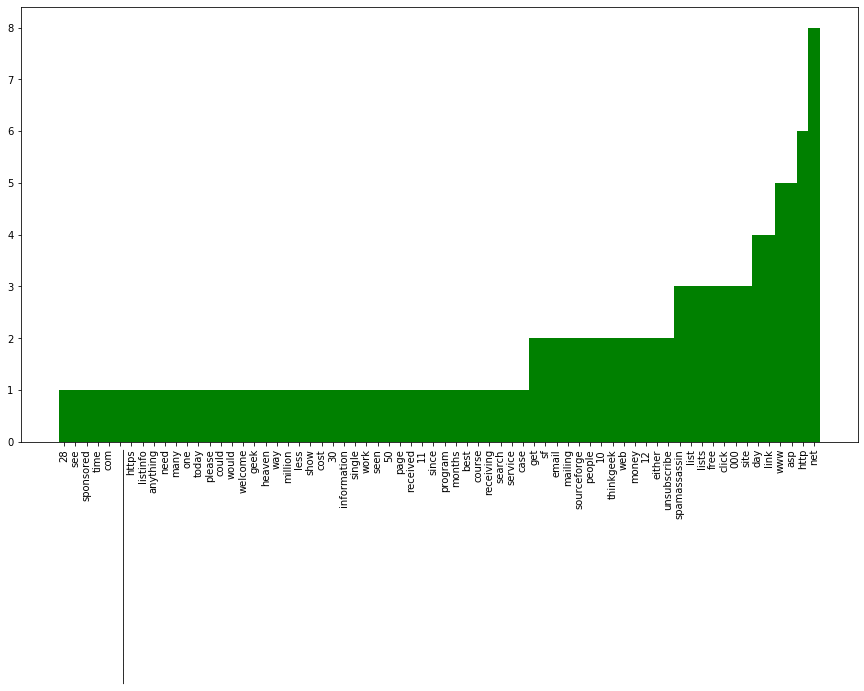

In [352]:
f, ax = plt.subplots(figsize=(15,8))
plt.bar(freq_dict.keys(), freq_dict.values(),width=1.0, color='g')
_ = plt.xticks(rotation=90)
